# Coherence analysis for the dimer paper

In these notes I will make sense of the coherence dynamics and steadystates for the dimer system. From the calculations ($\omega_1 = \omega_2 + \epsilon$) I find that 

$|\psi_-\rangle\langle\psi_+| +  |\psi_+\rangle\langle\psi_-| = \frac{2V}{\eta} |1\rangle\langle 1|-|2\rangle\langle 2|) - \frac{\epsilon}{2\eta} (|2\rangle\langle1|+|1\rangle\langle2|)$

which suggests that the real part of the eigenstate coherence incorporates both the real site coherence and the site population imbalance. We can numerically check this in the open 4LS to see if it holds true. Additionally,

$j = \dot{N_1} = 2 V \Im(<{|2\rangle\langle 1|}>) = 2 V \Im(<{|-\rangle\langle +|}>)$, where the outer $<.>$ are expectation values with the reduced density matrix. This means that the imaginary coherence is the same in both the site and exciton basis and that it is proportional to the particle current between sites.

### Preliminary checks & gaining insight
- Check that the real eigenstate coherence is equal to the sum shown above
    - Q: For a homodimer, does real e-coherence always equilibrate to zero? Strongly non-equilibrium systems? Perhaps a non-local dissipator won't cause coherence, but local ones (additive) ones do?
- Check that the imaginary eigenstate coherence is converged, see that it is equal to the site coherence and see if it goes to zero in the steady state (both with and without optical driving).
    - Q: What does it mean if it's non-zero? In the single-excitation subspace, should this be zero at steadystate due to conservation of particle number? In the dimer, is there a three way particle exchange occurring? 
- In mathematica, look at the Hamiltonian for small N with two RCs. Do the $\kappa_i$ act on separately on the monomer they are coupled to? Or do they cause transitions non-locally?
### Results we're aiming for
As it stands, eigenstate populations and the real and imaginary parts of coherences are of interest. I think the presence of electronic coherence in 2DFS experiments relates to site coherence (Mukamel for dummies), however, eigenstate coherence incorporates that anyway and is more interesting as it is only possible via the non-equilibrium/non-Markovian nature of the phonon baths. Its existence is a clear feature of the strong-coupling theory, so interpreting it is of interest to this work. The following will all be with symmetrical phonon baths $\alpha_1 = \alpha_2 = \alpha_{ph}$.

Indeed, it is not possible to alter the phonon-coupling rate in molecules, but it is interesting to know the $\alpha_{ph}$-dependence of various density matrix elements, particularly if they reach maxima as a function of $\alpha_{ph}$: for example, excitonic coherence may increase to a point as the phonons want to equilibrate the system into eigenstates which are less excitonic and more vibronic, but at some point there may be a localisation effect where V is suppressed. 4 figures: 2 should be ss populations as a function of $\alpha_{ph}$ at different system parameter regimes, the other two should be real and imaginary eigenstate coherence as a function of $\alpha_{ph}$ but for various parameter regimes.

Q: Is it important to look at temperature dependence?

Similarly to alpha dependence, the temperatures of the different baths will cause dissipation at different rates and towards different thermal states. THis non-equilibrium behaviour should be also effected by the different temperature baths $\frac{T_{EM}}{T_{ph}}$.


In [1]:
import os
import time

import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt


import phonons as RC
import optical as opt

from phonons import RC_mapping
from optical import L_non_rwa, L_phenom
from qutip import basis, qeye, enr_identity, enr_destroy, tensor, enr_thermal_dm, steadystate
from utils import *
import tests as check

OO = basis(4,0)
XO = basis(4,1)
OX = basis(4,2)
XX = basis(4,3)

site_coherence = OX*XO.dag()

OO_proj = OO*OO.dag()
XO_proj = XO*XO.dag()
OX_proj = OX*OX.dag()
XX_proj = XX*XX.dag()

sigma_m1 = OX*XX.dag() + OO*XO.dag()
sigma_m2 = XO*XX.dag() + OO*OX.dag()
sigma_x1 = sigma_m1+sigma_m1.dag()
sigma_x2 = sigma_m2+sigma_m2.dag()

I_dimer = qeye(4)

reload(RC)
reload(opt)

<module 'optical' from 'optical.pyc'>

In [46]:
n = iter(range(5,8))
lab = ['full', 'add. ns', 'add']
print [i for i in n]

[5, 6, 7]


In [47]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend(loc='best')"""
plt.figure()
for d in dat1:
    for i, l in enumerate(d):
        plt.plot(l.expect[4].real, label=lab[i])
        #plt.plot(l.expect[0].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend(loc='best')
plt.show()

NameError: name 'dat1' is not defined

<Figure size 432x288 with 0 Axes>

# Steady state plots for the paper
Choose the best model and use it to plot

4 $\alpha_{ph}$-dependence figures:

- 2 should be ss populations as a function of $\alpha_{ph}$ at 2 different system parameter regimes
- 2 should be (1) real and (2) imaginary eigenstate coherence as a function of $\alpha_{ph}$ for various parameter regimes.

4 $\frac{T_{EM}}{T_{ph}}$-dependence figures:
- populations at 2 different system parameter regimes
- real coherence for various parameters
- imaginary coherence for various parameters

## Convergence tests

I need to see (for a few different system parameter regimes and $\omega_0$, how well converged the steady states are. parameters I will test are: 

$\omega_2/\omega_0 =5, 20$

$\pi\alpha_{ph} = 0.005\omega_2, 0.1\omega_2, 0.2\omega_2, 0.5\omega_2$

Test between 5, 9: 5 combinations



97.009700970097
87.5087508750875
91.00910091009101
292.52925292529255


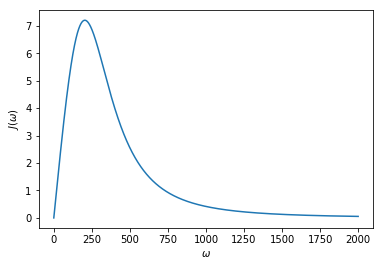

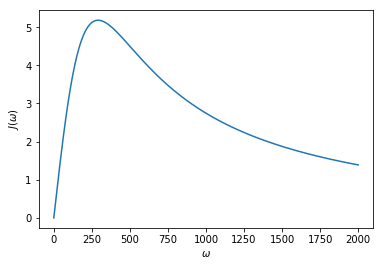

In [10]:
def plot_UD_SD(Gamma, alpha, w_0, eps=2000., ax=None):
    Omega = np.linspace(0,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, Gamma, w_0) for w in Omega])
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.plot(Omega, J_w)
    ax.set_xlabel(r"$\omega$")
    ax.set_ylabel(r"$J(\omega)$")
    if ax is None:
        plt.show()

def SD_peak_position(Gamma, alpha, w_0):
    Omega = np.linspace(0,w_0*50,10000)
    J_w = np.array([J_underdamped(w, alpha, Gamma, w_0) for w in Omega])
    return Omega[np.argmax(J_w)]

plot_UD_SD(500, 10, 300)
plot_UD_SD(8000, 10, 1500)
print SD_peak_position(50, 10, 100)
print SD_peak_position(100, 10, 100)
print SD_peak_position(500, 10, 200)
print SD_peak_position(8000, 10, 1500)

In [72]:
help(qt.enr_thermal_dm)

Help on function enr_thermal_dm in module qutip.states:

enr_thermal_dm(dims, excitations, n)
    Generate the density operator for a thermal state in the excitation-number-
    restricted state space defined by the `dims` and `exciations` arguments.
    See the documentation for enr_fock for a more detailed description of
    these arguments. The temperature of each mode in dims is specified by
    the average number of excitatons `n`.
    
    Parameters
    ----------
    dims : list
        A list of the dimensions of each subsystem of a composite quantum
        system.
    
    excitations : integer
        The maximum number of excitations that are to be included in the
        state space.
    
    n : integer
        The average number of exciations in the thermal state. `n` can be
        a float (which then applies to each mode), or a list/array of the same
        length as dims, in which each element corresponds specifies the
        temperature of the corresponding mode.


In [29]:
def make_initial_state(init_dimer_str, eops_dict, PARS):
    I_dimer = qeye(4)
    # Should also displace these states
    n1 = Occupation(PARS['w0_1'], PARS['T_1'])
    n2 = Occupation(PARS['w0_2'], PARS['T_2'])
    therm = tensor(I_dimer, qt.enr_thermal_dm([PARS['N_1'], PARS['N_2']], PARS['exc'], n1))
    return eops_dict[init_dimer_str]*therm

"""
fock_N1      = qt.enr_fock([N,N],N, (N/2,N/2))
fock_N2      = qt.enr_fock([N,N],N, (0,N))
fock_ground = qt.enr_fock([N,N],N, (N,0))
fock_ground2 = qt.enr_fock([N,N],N, (0,N))
"""


def make_expectation_operators(PARS):
    labels = [ 'OO', 'XO', 'OX', 'XX', 'site_coherence', 'bright', 'dark', 'eig_coherence',
             'RC1_position1', 'RC2_position', 'RC1_number', 'RC2_number']
    I = enr_identity([PARS['N_1'], PARS['N_2']], PARS['exc'])
    I_dimer = qeye(4)
    energies, states = exciton_states(PARS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    # electronic operators
     # site populations site coherences, eig pops, eig cohs
    subspace_ops = [OO_proj, XO_proj, OX_proj, XX_proj,site_coherence, 
                   bright_vec*bright_vec.dag(), dark_vec*dark_vec.dag(),
                   dark_vec*bright_vec.dag()]
    # put operators into full RC tensor product basis
    fullspace_ops = [tensor(op, I) for op in subspace_ops]
    # RC operators
    # RC positions, RC number state1, RC number state1, RC upper N fock, RC ground fock
    
    N_1, N_2, exc = PARS['N_1'], PARS['N_2'], PARS['exc']
    a_enr_ops = enr_destroy([N_1, N_2], exc)
    position1 = a_enr_ops[0].dag() + a_enr_ops[0]
    position2 = a_enr_ops[1].dag() + a_enr_ops[1]
    number1   = a_enr_ops[0].dag()*a_enr_ops[0]
    number2   = a_enr_ops[1].dag()*a_enr_ops[1]
    
    subspace_ops = [position1, position2, number1, number2]
    fullspace_ops += [tensor(I_dimer, op) for op in subspace_ops]
    
    
    return dict((key_val[0], key_val[1]) for key_val in zip(labels, fullspace_ops))



In [27]:
def dynamics(bias=100., w_2=2000., V = 100., pialpha_prop=0.1,
                                 T_EM=0., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 num_cpus=1, w_0=200, Gamma=50., 
                                dir_name="dynamics", N=3,
                                tf=0.5, incs=2500, init_dimer='XO', silent=False):
    N_1 = N_2 = N
    exc = N
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    alpha = w_2*pialpha_prop/pi
    
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = (w_2*dipole_2)/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = T_ph, T_ph # Phonon bath temperature
    
    Gamma_1 = Gamma_2 = Gamma
    w0_2, w0_1 = w_0, w_0 # underdamped SD parameter omega_0
    if not silent:
        plot_UD_SD(Gamma_1, w_2*pialpha_prop/pi, w_0, eps=w_2)
    w_xx = w_2 + w_1
    if not silent:
        print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}. N={}.".format(gap, phonon_energy, 
                                                                                 SD_peak_position(Gamma, 1, w_0), 
                                                                                           N)
    
    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    if N>7:
        silent = False
    
    PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
    PARAMS.update({'N_1': N_1, 'N_2': N_2})
    PARAMS.update({'exc': exc})
    
    I = enr_identity([N_1,N_2], exc)
    ''' generate the RC liouvillian '''
    
    # Create the phonon liouvillian
    
    L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                            silent=silent, 
                                                            shift=True)
    L = L_RC
    if abs(alpha_EM)>0:
        # electromagnetic bath liouvillians
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        L+=L_EM_full
    timelist = np.linspace(0, tf, incs)
    # get all the useful operators we might need
    eops_dict =  make_expectation_operators(PARAMS)
    # unpack them all in asensible order
    labels = ['OO', 'XO', 'OX', 'XX', 'site_coherence', 
              'bright', 'dark', 'eig_coherence', 
              'RC1_position1' , 'RC2_position', 
              'RC1_number'    , 'RC2_number']
    eops  = [eops_dict[l] for l in labels]
    rho_0 = make_initial_state(init_dimer, eops_dict, PARAMS)
    try:
        pb = not silent
        if not pb:
            pb = None
        data  = qt.mesolve(H[1], rho_0, timelist, c_ops=L, e_ops=eops, 
                                                progress_bar=pb)
        
        # Save the data
        j = 1
        saved = False
        while not saved:
            directory = 'DATA/'+dir_name+'_'+str(j)
            if not os.path.exists(directory):
                os.makedirs(directory)
                save_obj(data, directory+'/dynamics')
                save_obj(PARAMS, directory+'/PARAMS')
                save_obj(timelist, directory+'/timelist')
                saved = True
                print "Files saved at {}".format(directory)
            else:
                j+=1
        return timelist, data
    except Exception as err:
        print ("omega_0 = {}, Gamma = {} and alpha = {} didn't work because").format(w_0, Gamma, alpha)
        print (err)
        return timelist, None

def dynamics_plotter(num, plot_SD=True, dir_name="dynamics", 
                     print_params=False, obs_name_list=['XO', 'OX']):
    
    directory = 'DATA/'+dir_name+'_'+str(num)
    data = load_obj(directory+'/dynamics')
    PARAMS = load_obj(directory+'/PARAMS')
    timelist = load_obj(directory+'/timelist')  # reverse ordering -> lower_N-higher_N
    if print_params:
        print( PARAMS)
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    
    labels = ['OO', 'XO', 'OX', 'XX', 'site_coherence', 
              'bright', 'dark', 'eig_coherence', 
              'RC1_position1', 'RC2_position', 
              'RC1_number', 'RC2_number']
    
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    
    f, axes = plt.subplots(1,2, figsize=(20,4))
    # don't deal with RC variables yet
    '''str_rep_of_namelist = ''.join(obs_name_list)
    # check if we want to make an axis for RC variables
    if 'RC' in str_rep_of_namelist:
        f2, axes2 = plt.subplots(1,2, figsize=(20,4))'''
    for l in obs_name_list:
        idx = labels.index(l)
        d = data.expect[idx]
        
        if 'coherence' in l:
            axes[1].plot(timelist, d.real, label='real', color=colors[idx])
            axes[1].plot(timelist, d.imag, label='imag', color=colors[idx+1])
        else:
            axes[0].plot(timelist, d, label=l, color=colors[idx])
    plt.xlabel(r'Time')
    plt.ylabel(r'Observable')
    plt.legend()
    plt.show()
    return timelist, data


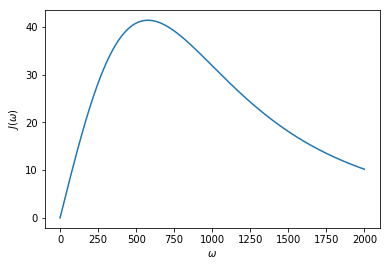

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 575.057505751.
Including optical dissipator
10.0%. Run time:   0.51s. Est. time left: 00:00:00:04
20.0%. Run time:   0.85s. Est. time left: 00:00:00:03
30.0%. Run time:   1.18s. Est. time left: 00:00:00:02
40.0%. Run time:   1.52s. Est. time left: 00:00:00:02
50.0%. Run time:   1.88s. Est. time left: 00:00:00:01
60.0%. Run time:   2.22s. Est. time left: 00:00:00:01
70.0%. Run time:   2.54s. Est. time left: 00:00:00:01
80.0%. Run time:   2.87s. Est. time left: 00:00:00:00
90.0%. Run time:   3.21s. Est. time left: 00:00:00:00
Total run time:   3.54s
Files saved at DATA/dynamics_43


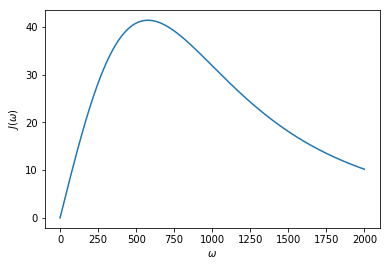

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 575.057505751.
Including optical dissipator
10.0%. Run time:   2.42s. Est. time left: 00:00:00:21
20.0%. Run time:   5.06s. Est. time left: 00:00:00:20
30.0%. Run time:   7.69s. Est. time left: 00:00:00:17
40.0%. Run time:  10.29s. Est. time left: 00:00:00:15
50.0%. Run time:  12.90s. Est. time left: 00:00:00:12
60.0%. Run time:  15.27s. Est. time left: 00:00:00:10
70.0%. Run time:  17.78s. Est. time left: 00:00:00:07
80.0%. Run time:  20.17s. Est. time left: 00:00:00:05
90.0%. Run time:  22.30s. Est. time left: 00:00:00:02
Total run time:  24.54s
Files saved at DATA/dynamics_44


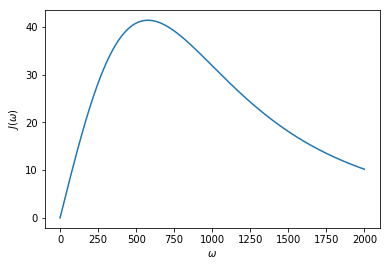

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 575.057505751.
Including optical dissipator
10.0%. Run time:  39.18s. Est. time left: 00:00:05:52
20.0%. Run time:  76.32s. Est. time left: 00:00:05:05
30.0%. Run time: 114.06s. Est. time left: 00:00:04:26
40.0%. Run time: 150.76s. Est. time left: 00:00:03:46
50.0%. Run time: 185.51s. Est. time left: 00:00:03:05
60.0%. Run time: 219.03s. Est. time left: 00:00:02:26
70.0%. Run time: 253.39s. Est. time left: 00:00:01:48
80.0%. Run time: 289.29s. Est. time left: 00:00:01:12
90.0%. Run time: 325.32s. Est. time left: 00:00:00:36
Total run time: 359.83s
Files saved at DATA/dynamics_45


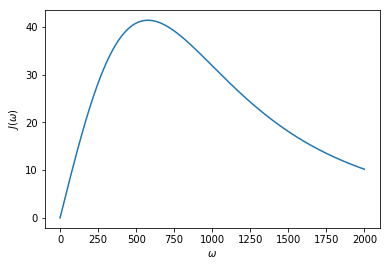

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 575.057505751.
The operators took 21.3644270897 and have dimension 104.
Building the RC Liouvillian took 21.828 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Including optical dissipator
Full optical Liouvillian took 23.2787311077 seconds.
10.0%. Run time:  29.37s. Est. time left: 00:00:04:24
20.0%. Run time:  55.39s. Est. time left: 00:00:03:41
30.0%. Run time:  83.46s. Est. time left: 00:00:03:14
40.0%. Run time: 111.46s. Est. time left: 00:00:02:47
50.0%. Run time: 139.14s. Est. time left: 00:00:02:19
60.0%. Run time: 166.43s. Est. time left: 00:00:01:50
70.0%. Run time: 195.43s. Est. time left: 00:00:01:23
80.0%. Run time: 227.69s. Est. time left: 00:00:00:56
90.0%. Run time: 259.62s. Est. time left: 00:00:00:28
Total run time: 290.44s
Files saved at DATA/dynamics_46


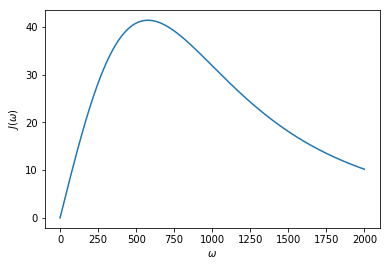

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 575.057505751.
The operators took 36.3113820553 and have dimension 136.
Building the RC Liouvillian took 37.346 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Including optical dissipator
Full optical Liouvillian took 39.8740828037 seconds.
10.0%. Run time: 195.48s. Est. time left: 00:00:29:19
20.0%. Run time: 399.61s. Est. time left: 00:00:26:38
30.0%. Run time: 598.16s. Est. time left: 00:00:23:15
40.0%. Run time: 792.88s. Est. time left: 00:00:19:49


In [ ]:
init_dimer='OO'
w_2=2000.
w_0=1000.
Gamma = 2000.
t, d300_1 = dynamics(N=3, w_0=w_0, alpha_EM=1., T_EM=300., Gamma=Gamma,
                                             init_dimer=init_dimer, w_2=2000.) 
t, d300_2 = dynamics(N=4, w_0=w_0, alpha_EM=1., T_EM=300., Gamma=Gamma, init_dimer=init_dimer) 
t, d300_3 = dynamics(N=5, w_0=w_0, alpha_EM=1., T_EM=300., Gamma=Gamma, init_dimer=init_dimer)
t, d300_4 = dynamics(N=6, w_0=w_0, alpha_EM=1., T_EM=300., Gamma=Gamma, init_dimer=init_dimer)
t, d300_5 = dynamics(N=7, w_0=w_0, alpha_EM=1., T_EM=300., Gamma=Gamma, init_dimer=init_dimer)

t, d2000_1 = dynamics(N=3, w_0=w_0, alpha_EM=1., T_EM=2000., Gamma=Gamma, init_dimer=init_dimer) 
t, d2000_2 = dynamics(N=4, w_0=w_0, alpha_EM=1., T_EM=2000., Gamma=Gamma, init_dimer=init_dimer) 
t, d2000_3 = dynamics(N=5, w_0=w_0, alpha_EM=1., T_EM=2000., Gamma=Gamma, init_dimer=init_dimer)
t, d2000_4 = dynamics(N=6, w_0=w_0, alpha_EM=1., T_EM=2000., Gamma=Gamma, init_dimer=init_dimer)
t, d2000_5 = dynamics(N=7, w_0=w_0, alpha_EM=1., T_EM=2000., Gamma=Gamma, init_dimer=init_dimer)

# Iterating a whole host of parameters

In [ ]:
from itertools import combinations_with_replacement

def permutations_with_replacement(e):
    for i in e:
        for j in e:
            for k in e:
                yield (i,j,k)

sizes = ['s', 'm', 'l']
combs = []

init_dimer='OO'
w_2 = 2000.

params = dict({'Gamma': dict({'s' : 30, 'm' : 200, 'l' : 1500}),
             'w_0'  : dict({'s' : 50, 'm' : 200, 'l' : 1500}),
                'alpha': dict({'s' : 10, 'm' : 50 , 'l' : 200})})
# have already calculated the below parameters
combs = [i for i in combinations_with_replacement(sizes, 3)]

N_values = range(3,10)
for perm in permutations_with_replacement(sizes):
    if perm not in combs:
        # Gamma, omega_0, alpha
        Gamma = params['Gamma'][perm[0]]
        w_0 = params['w_0'][perm[1]]
        alpha = params['alpha'][perm[2]]
        pialpha_prop = (pi*alpha)/w_2
        label_str = ''.join(perm)
        for N in N_values:
            _, _ = dynamics(N=N, w_0=w_0, Gamma=Gamma, pialpha_prop=pialpha_prop,
                            alpha_EM=1., T_EM=2000.,  silent = True,
                            init_dimer=init_dimer, dir_name='dynamics_{}'.format(label_str))



Files saved at DATA/dynamics_sms_1
Files saved at DATA/dynamics_sms_2
Files saved at DATA/dynamics_sms_3
Files saved at DATA/dynamics_sms_4
Files saved at DATA/dynamics_sms_5
The operators took 71.8402938843 and have dimension 172.
Building the RC Liouvillian took 74.033 seconds.
****************************************************************
It is 29584by29584. The full basis would be 65536by65536
Full optical Liouvillian took 72.0389890671 seconds.
10.0%. Run time:  41.48s. Est. time left: 00:00:06:13
20.0%. Run time:  93.90s. Est. time left: 00:00:06:15
30.0%. Run time: 147.78s. Est. time left: 00:00:05:44
40.0%. Run time: 204.92s. Est. time left: 00:00:05:07
50.0%. Run time: 261.60s. Est. time left: 00:00:04:21
60.0%. Run time: 319.22s. Est. time left: 00:00:03:32
70.0%. Run time: 374.67s. Est. time left: 00:00:02:40
80.0%. Run time: 432.62s. Est. time left: 00:00:01:48
90.0%. Run time: 486.71s. Est. time left: 00:00:00:54
Total run time: 543.82s
Files saved at DATA/dynamics_sms_6

[('s', 's', 's'), ('s', 's', 'm'), ('s', 's', 'l'), ('s', 'm', 'm'), ('s', 'm', 'l'), ('s', 'l', 'l'), ('m', 'm', 'm'), ('m', 'm', 'l'), ('m', 'l', 'l'), ('l', 'l', 'l')]
trying  DATA/dynamics_sms_1
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_2
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_3
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_4
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_5
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_6
('could not plot because ', IOError(2, 'No such file or directory'))
trying  DATA/dynamics_sms_7
('could not plot because ', IOError(2, 'No such file or directory'))


UnboundLocalError: local variable 'PARAMS' referenced before assignment

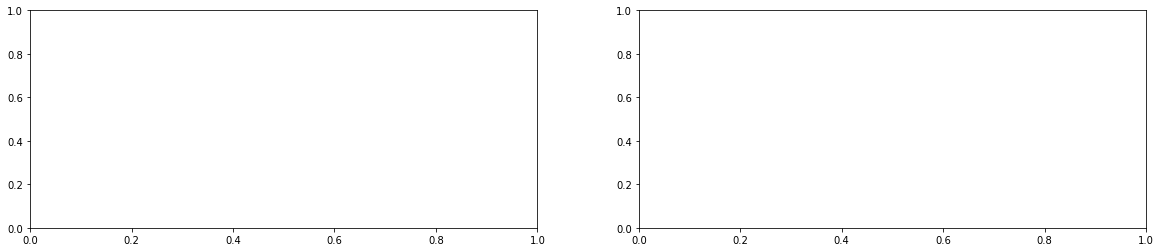

In [25]:
def plot_dynamics_converge(comb, observable, dir_name="dynamics", plot_SD=True):
    f, axes = plt.subplots(1,2, figsize=(20,4))
    
    labels = ['OO', 'XO', 'OX', 'XX', 'site_coherence', 
                      'bright', 'dark', 'eig_coherence', 
                      'RC1_position1', 'RC2_position', 
                      'RC1_number', 'RC2_number']
    assert observable in labels
    idx = labels.index(observable)
    
    _dir_name = dir_name+"_"+''.join(comb)+"_"
    for num in range(1,len(N_values)+1):
        
        try:
            directory = 'DATA/'+_dir_name+str(num)
            print "trying ", directory
            data = load_obj(directory+'/dynamics')
            PARAMS = load_obj(directory+'/PARAMS')
            timelist = load_obj(directory+'/timelist')  # reverse ordering -> lower_N-higher_N
            
            colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
            axes[1].plot(timelist, data.expect[idx], label="N={}".format(PARAMS['N_1']))
        except Exception as err:
            print ("could not plot because ", err)
    if plot_SD:
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.,ax=axes[0])
    plt.xlabel(r'Time')
    plt.ylabel(r'Observable')
    plt.legend()
    plt.show()
    return timelist, data

from itertools import combinations_with_replacement
sizes = ['s', 'm', 'l']
combs = []

init_dimer='OO'
w_2 = 2000.

params = dict({'Gamma': dict({'s' : 30, 'm' : 200, 'l' : 1500}),
             'w_0'  : dict({'s' : 50, 'm' : 200, 'l' : 1500}),
                'alpha': dict({'s' : 10, 'm' : 50 , 'l' : 200})})

N_values = range(3,10)
observable = "site_coherence"



for perm in permutations_with_replacement(sizes):
    if perm not in combs:
        plot_dynamics_converge(perm, observable, dir_name="dynamics")

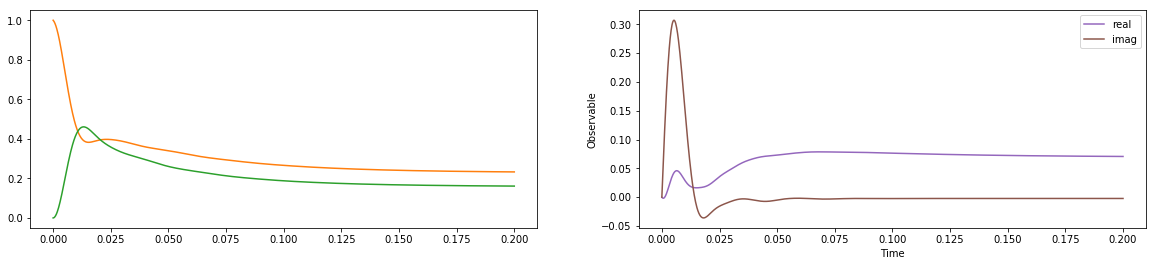

****************************************
RC 1 has occupation of: 4.01904476819
RC 1 has fock state 8 occupation: 6.47396016659e-11
RC 2 has occupation of: 3.95885739089
RC 2 has fock state 8 occupation: 6.53196790358e-11


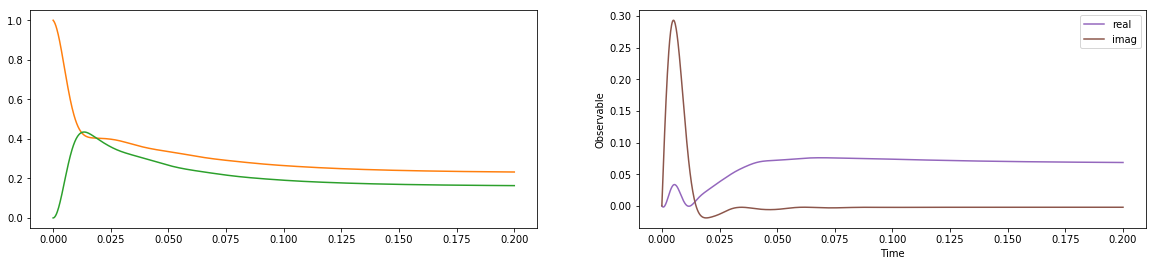

****************************************
RC 1 has occupation of: 4.01661659607
RC 1 has fock state 8 occupation: 0.0
RC 2 has occupation of: 3.96176063789
RC 2 has fock state 8 occupation: 0.0


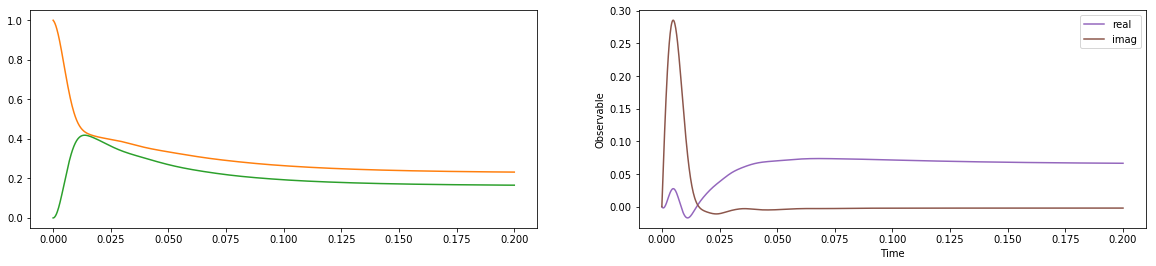

****************************************
RC 1 has occupation of: 3.99560095863
RC 1 has fock state 8 occupation: 1.79166329004e-10
RC 2 has occupation of: 3.98173969283
RC 2 has fock state 8 occupation: 1.81357630129e-10


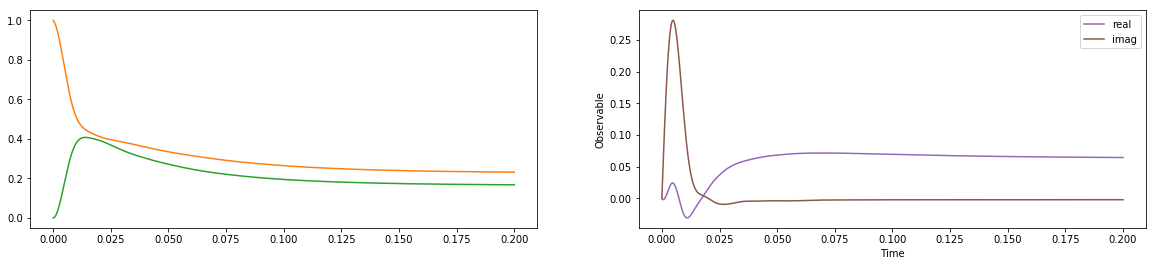

****************************************
RC 1 has occupation of: 4.00079313139
RC 1 has fock state 8 occupation: 1.08900629291e-10
RC 2 has occupation of: 3.98898348461
RC 2 has fock state 8 occupation: 1.12227906495e-10


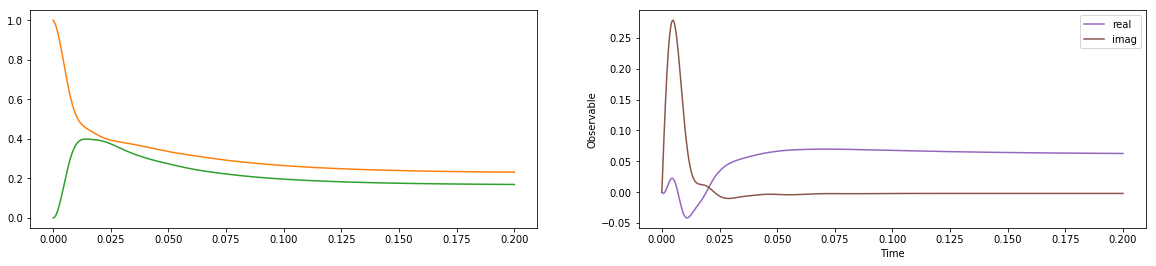

****************************************
RC 1 has occupation of: 3.98378116601
RC 1 has fock state 8 occupation: 1.08594281958e-10
RC 2 has occupation of: 3.96079318805
RC 2 has fock state 8 occupation: 1.08520716329e-10


(array([0.        , 0.0002002 , 0.0004004 , 0.0006006 , 0.0008008 ,
        0.001001  , 0.0012012 , 0.0014014 , 0.0016016 , 0.0018018 ,
        0.002002  , 0.0022022 , 0.0024024 , 0.0026026 , 0.0028028 ,
        0.003003  , 0.0032032 , 0.0034034 , 0.0036036 , 0.0038038 ,
        0.004004  , 0.0042042 , 0.0044044 , 0.0046046 , 0.0048048 ,
        0.00500501, 0.00520521, 0.00540541, 0.00560561, 0.00580581,
        0.00600601, 0.00620621, 0.00640641, 0.00660661, 0.00680681,
        0.00700701, 0.00720721, 0.00740741, 0.00760761, 0.00780781,
        0.00800801, 0.00820821, 0.00840841, 0.00860861, 0.00880881,
        0.00900901, 0.00920921, 0.00940941, 0.00960961, 0.00980981,
        0.01001001, 0.01021021, 0.01041041, 0.01061061, 0.01081081,
        0.01101101, 0.01121121, 0.01141141, 0.01161161, 0.01181181,
        0.01201201, 0.01221221, 0.01241241, 0.01261261, 0.01281281,
        0.01301301, 0.01321321, 0.01341341, 0.01361361, 0.01381381,
        0.01401401, 0.01421421, 0.01441441, 0.01

In [136]:
dynamics_plotter(5, plot_SD=False, 
                     print_params=False, 
                 obs_name_list=['XO', 'OX', 'site_coherence'])
dynamics_plotter(6, plot_SD=False, 
                     print_params=False, 
                 obs_name_list=['XO', 'OX', 'site_coherence'])
dynamics_plotter(7, plot_SD=False, 
                     print_params=False, 
                 obs_name_list=['XO', 'OX', 'site_coherence'])
dynamics_plotter(8, plot_SD=False, 
                     print_params=False, 
                 obs_name_list=['XO', 'OX', 'site_coherence'])
dynamics_plotter(9, plot_SD=False, 
                     print_params=False, 
                 obs_name_list=['XO', 'OX', 'site_coherence'])

In [133]:
def convergence(bias=100., w_2=2000., V = 100., pialpha_prop=0.1,
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=5, upper_N=9, 
                                 num_cpus=1, w_0=None, Gamma=50., 
                                dir_name="converge"):
    
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = (w_2*dipole_2)/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = T_ph, T_ph # Phonon bath temperature
    
    Gamma_1 = Gamma_2 = Gamma
    if w_0 == None:
        w0_2, w0_1 = gap+30, gap+30 # underdamped SD parameter omega_0
        upper_N = upper_N #N_across_gap(w_2, gap)
    else:
        w0_2, w0_1 = w_0, w_0 # underdamped SD parameter omega_0
        upper_N = upper_N
    plot_UD_SD(Gamma_1, w_2*pialpha_prop/pi, w_0, eps=w_2)
    w_xx = w_2 + w_1
    print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}.".format(gap, phonon_energy, 
                                                                                 SD_peak_position(Gamma, 1, w_0))
    I_dimer = qeye(4)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.
    
    # electromagnetic bath liouvillians
    N_vals = range(lower_N, upper_N+1)[::-1]
    print N_vals
    steady_states = []
    
    for i, N in enumerate(N_vals):
        alpha = w_2*pialpha_prop/pi
        N_1 = N_2 = N
        exc = N
        
        silent = False
        if N<=5:
            silent = True
        
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                                silent=silent, 
                                                                shift=True)
        L = L_RC
        if abs(alpha_EM)>0:
            print "Including optical dissipator"
            L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
            L+=L_EM_full
        ti = time.time()
        
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 70
                dt = 1e-3
                if N>8:
                    ff = 60
                    dt = 5e-2
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        calculated = False
        ss = 0
        while not calculated: 
            try:
                ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                     fill_factor=ff, drop_tol=dt)
                calculated=True
            except:
                dt-=3e-3
                print "Calculation failed. Increasing tolerance."
        steady_states.append(ss)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)
    j = 1
    saved = False
    while not saved:
        directory = 'DATA/'+dir_name+'_'+str(j)
        if not os.path.exists(directory):
            os.makedirs(directory)
            save_obj(steady_states, directory+'/steady_states')
            save_obj(PARAMS, directory+'/PARAMS')
            save_obj(N_vals, directory+'/N_vals')
            saved = True
            print "Files saved at {}".format(directory)
        else:
            j+=1

def steadystate_occupation(num, dir_name="converge"):
    # Prints out the occupation of each RC
    print "****************************************"
    directory = 'DATA/'+dir_name+'_'+str(num)
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')
    
    largest_N_idx = 0 # order is reversed to calc largest first
    ss = steady_states[largest_N_idx]
    
    N = N_vals[largest_N_idx]
    a_temp = enr_destroy([N,N],N)
    
    #annihilation = qt.destroy(N)
    sys_dim = ss.dims[0][0]
    for i in range(2):
        print "RC {} has occupation of: {}".format (i+1, (ss*tensor(qeye(sys_dim), 
                                                            a_temp[i].dag()*a_temp[i])).tr())
        tup = (0,0)
        if i ==0:
            tup = (PARAMS['exc']-1,0)
        elif i ==1:
            tup = (0,PARAMS['exc']-1)
        else:
            raise ValueError("Only two RCs will work for this code.")
        fock_N = qt.enr_fock([N,N],N, tup)
        fock_expec = (ss*tensor(qeye(sys_dim), fock_N*fock_N.dag())).tr()
        print "RC {} has fock state {} occupation: {}".format (i+1, N, fock_expec)
            
def convergence_plotter(num, plot_SD=True, dir_name="converge"):
    directory = 'DATA/'+dir_name+'_'+str(num)
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')  # reverse ordering -> lower_N-higher_N
    print PARAMS
    if plot_SD:
        print PARAMS["w0_1"]
        plot_UD_SD(PARAMS["Gamma_1"], PARAMS["alpha_1"], PARAMS["w0_1"], eps=2000.)
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    e_ops = [OO_proj, XO_proj, OX_proj, XX_proj, site_coherence]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())   
        expectation_values.append(dat)
    
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = [ '1', '2', 'XX']
    ids = [1,2]
    for i, l in zip(ids, labels):
        plt.plot(N_vals[::-1], np.array(expectation_values[i]).real[::-1], label=l, color=colors[i])
    plt.xlabel(r'N')
    plt.ylabel(r'Population')
    plt.legend()
    
    plt.figure()
    plt.plot(N_vals[::-1], np.array(expectation_values[4]).real[::-1], label='real', color=colors[0])
    plt.plot(N_vals[::-1], np.array(expectation_values[4]).imag[::-1], label='imag', color=colors[1])
    plt.xlabel(r'N')
    plt.ylabel(r'Site coherence')
    plt.legend()
    plt.show()
    steadystate_occupation(num)
    return N_vals, expectation_values



In [23]:
V = 200.
bias=200.
w_2 = 2000.0

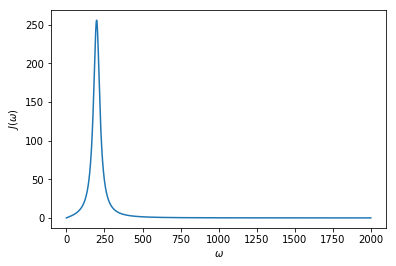

Gap is 447.2135955. Phonon thermal energy is 208.5. Phonon SD peak is 198.01980198.
[4, 3, 2]
Files saved at DATA/converge_phonons_5


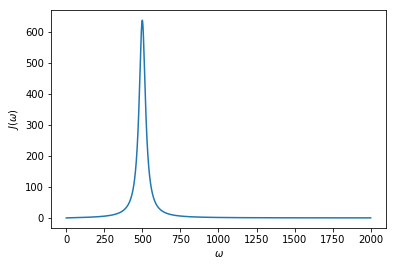

Gap is 447.2135955. Phonon thermal energy is 208.5. Phonon SD peak is 500.050005001.
[8, 7, 6, 5, 4, 3, 2]


KeyboardInterrupt: 

In [29]:
# No optical field
alpha_EM = 0
dir_name="converge_phonons"

convergence(bias=bias, w_2=w_2, V = V, pialpha_prop=0.1,
                                 T_EM=0., T_ph =300., 
                                 alpha_EM=alpha_EM, shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=200, Gamma=50., dir_name=dir_name)
convergence(bias=bias, w_2=w_2, V = V, pialpha_prop=0.1,
                                 T_EM=0., T_ph =300., 
                                 alpha_EM=alpha_EM, shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=500, Gamma=50., dir_name=dir_name)
convergence(bias=bias, w_2=w_2, V = V, pialpha_prop=0.1,
                                 T_EM=0., T_ph =300., 
                                 alpha_EM=alpha_EM, shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=1000, Gamma=50., dir_name=dir_name)
convergence(bias=bias, w_2=w_2, V = V, pialpha_prop=0.1,
                                 T_EM=0., T_ph =300., 
                                 alpha_EM=alpha_EM, shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=1000, Gamma=50., dir_name=dir_name)

No zero file
{'kappa_2': 141.4213562373095, 'kappa_1': 141.4213562373095, 'T_EM': 0.0, 'bias': 200.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50.0, 'Gamma_2': 50.0, 'mu': 0.9090909090909091, 'num_cpus': 1, 'w_xx': 4200.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 200, 'w0_2': 200, 'V': 200.0, 'w_1': 2200.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 0, 'N_1': 2, 'N_2': 2, 'shift2': 100.0, 'shift1': 100.0, 'gamma_1': 0.039788735772973836, 'gamma_2': 0.039788735772973836}
200


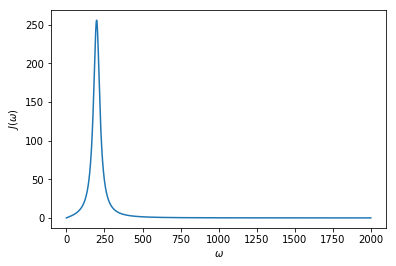

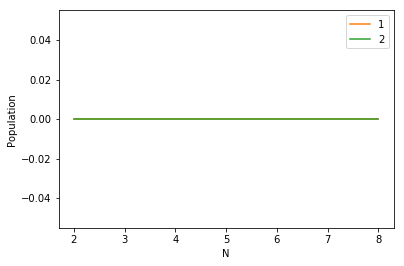

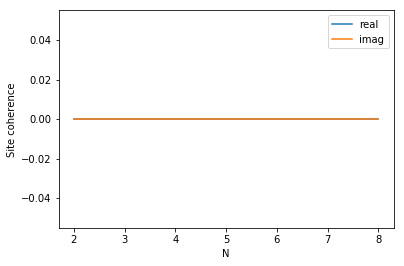

****************************************
RC 1 has occupation of: 1.71991082561
RC 1 has fock state 4 occupation: 0.0747513396765
RC 2 has occupation of: 1.71724757802
RC 2 has fock state 4 occupation: 0.0745797810954
{'kappa_2': 223.60679774997897, 'kappa_1': 223.60679774997897, 'T_EM': 0.0, 'bias': 200.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50.0, 'Gamma_2': 50.0, 'mu': 0.9090909090909091, 'num_cpus': 1, 'w_xx': 4200.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 500, 'w0_2': 500, 'V': 200.0, 'w_1': 2200.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 0, 'N_1': 2, 'N_2': 2, 'shift2': 100.0, 'shift1': 100.0, 'gamma_1': 0.015915494309189534, 'gamma_2': 0.015915494309189534}
500


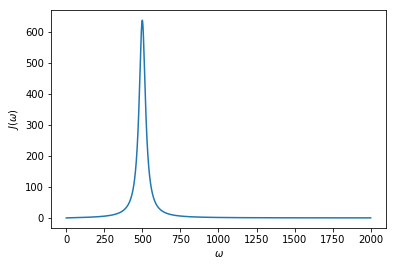

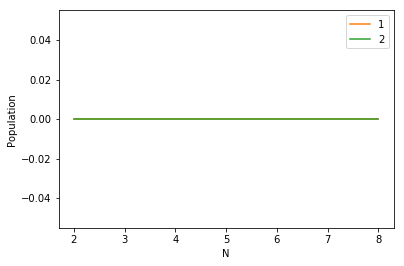

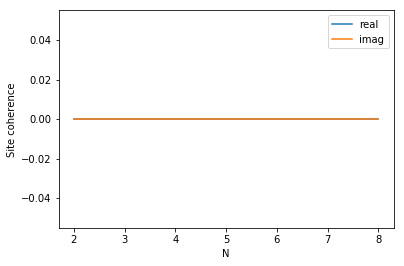

****************************************
RC 1 has occupation of: 3.94622069448
RC 1 has fock state 8 occupation: 0.011738893565
RC 2 has occupation of: 3.9185450487
RC 2 has fock state 8 occupation: 0.0115695508735
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 0.0, 'bias': 200.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50.0, 'Gamma_2': 50.0, 'mu': 0.9090909090909091, 'num_cpus': 1, 'w_xx': 4200.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2200.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.007957747154594767, 'gamma_2': 0.007957747154594767}
1000


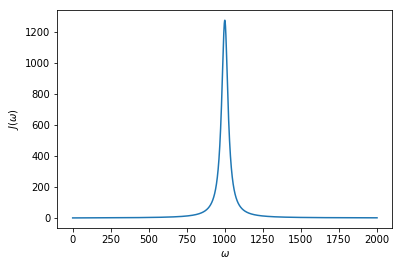

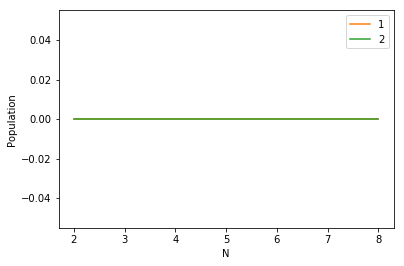

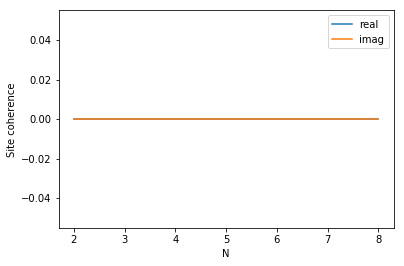

****************************************
RC 1 has occupation of: 3.94872298332
RC 1 has fock state 8 occupation: 0.0118521008668
RC 2 has occupation of: 3.91467415845
RC 2 has fock state 8 occupation: 0.0116166877202
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 0.0, 'bias': 200.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50.0, 'Gamma_2': 50.0, 'mu': 0.9090909090909091, 'num_cpus': 1, 'w_xx': 4200.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2200.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.007957747154594767, 'gamma_2': 0.007957747154594767}
1000


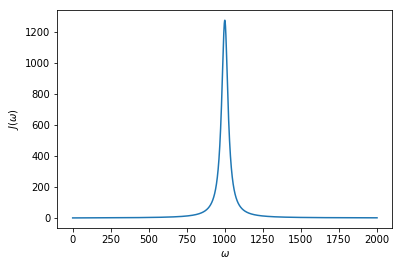

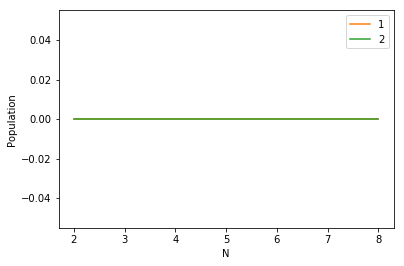

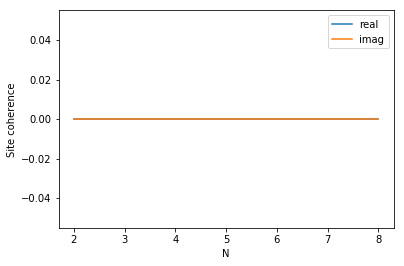

****************************************
RC 1 has occupation of: 3.94701790674
RC 1 has fock state 8 occupation: 0.0117499780908
RC 2 has occupation of: 3.9290675617
RC 2 has fock state 8 occupation: 0.0116689851308


([8, 7, 6, 5, 4, 3, 2],
 [[0.9999999999998653,
   0.9999999999998932,
   0.9999999999999353,
   0.9999999999999998,
   1.0,
   1.0,
   1.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

In [47]:
try:
    convergence_plotter(0, plot_SD=True, dir_name=dir_name)
except:
    print "No zero file"
    pass
convergence_plotter(1, plot_SD=True, dir_name=dir_name)
convergence_plotter(2, plot_SD=True, dir_name=dir_name)
convergence_plotter(3, plot_SD=True, dir_name=dir_name)
convergence_plotter(4, plot_SD=True, dir_name=dir_name)

In [ ]:
2000

$K_B T_{EM}$

In [72]:
KbTem = 0.695*6000
print 2000*(KbTem/(1.4*8080))


737.270155587


In [ ]:
convergence(bias=bias, w_2=w_2, V = V, pialpha_prop=0.1,
                                 T_EM=2000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                 lower_N=2, upper_N=8, 
                                 num_cpus=1, w_0=1500, Gamma=6000)

Gap is 447.2135955. Phonon thermal energy is 208.5. Phonon SD peak is 397.539753975.
[8, 7, 6, 5, 4, 3, 2]
The operators took 70.3093588352 and have dimension 172.
Building the RC Liouvillian took 72.570 seconds.
****************************************************************
It is 29584by29584. The full basis would be 65536by65536
Full optical Liouvillian took 76.4642379284 seconds.
1  N= 8
Calculation failed. Increasing tolerance.


{'kappa_2': 500.0, 'kappa_1': 500.0, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 318.3098861837907, 'alpha_1': 318.3098861837907, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 300, 'Gamma_2': 300, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 500, 'w0_2': 500, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 500.0, 'shift1': 500.0, 'gamma_1': 0.09549296585513721, 'gamma_2': 0.09549296585513721}
500


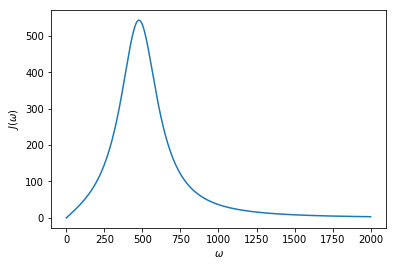

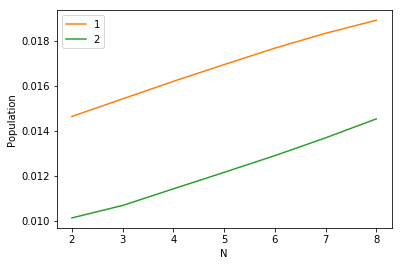

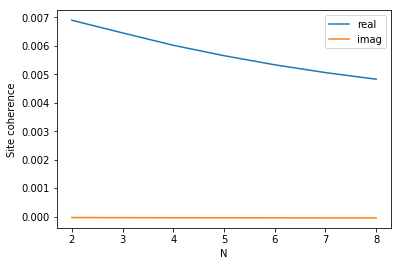

****************************************
RC 1 has occupation of: 3.94622069448
RC 1 has fock state 8 occupation: 0.011738893565
RC 2 has occupation of: 3.9185450487
RC 2 has fock state 8 occupation: 0.0115695508735
{'kappa_2': 500.0, 'kappa_1': 500.0, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 318.3098861837907, 'alpha_1': 318.3098861837907, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 100, 'Gamma_2': 100, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 500, 'w0_2': 500, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 500.0, 'shift1': 500.0, 'gamma_1': 0.03183098861837907, 'gamma_2': 0.03183098861837907}
500


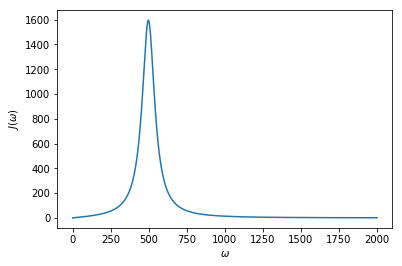

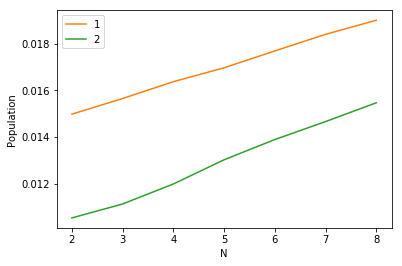

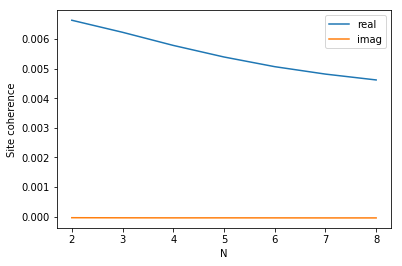

****************************************
RC 1 has occupation of: 3.94872298332
RC 1 has fock state 8 occupation: 0.0118521008668
RC 2 has occupation of: 3.91467415845
RC 2 has fock state 8 occupation: 0.0116166877202
{'kappa_2': 223.60679774997897, 'kappa_1': 223.60679774997897, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 100, 'Gamma_2': 100, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 500, 'w0_2': 500, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.0, 'shift1': 100.0, 'gamma_1': 0.03183098861837907, 'gamma_2': 0.03183098861837907}
500


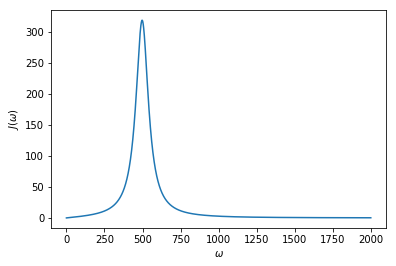

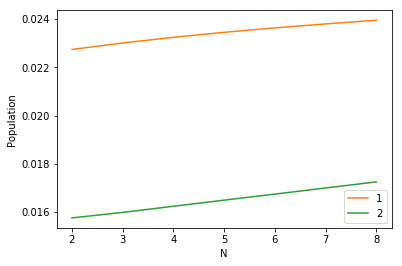

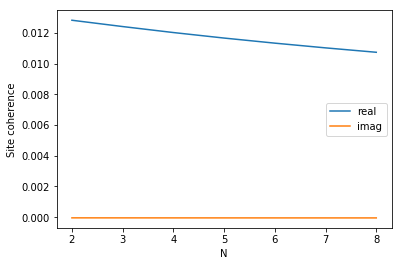

****************************************
RC 1 has occupation of: 3.94701790674
RC 1 has fock state 8 occupation: 0.0117499780908
RC 2 has occupation of: 3.9290675617
RC 2 has fock state 8 occupation: 0.0116689851308
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 100, 'Gamma_2': 100, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.015915494309189534, 'gamma_2': 0.015915494309189534}
1000


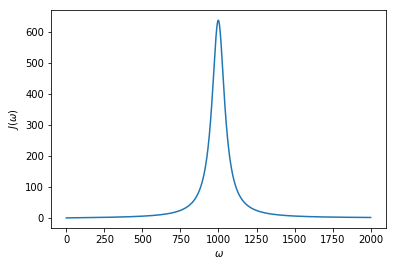

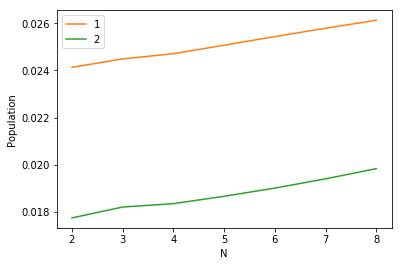

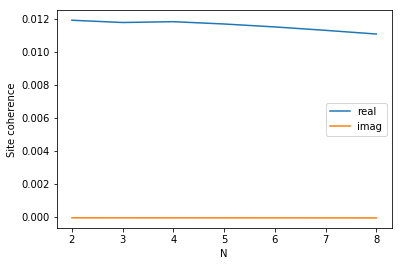

****************************************
RC 1 has occupation of: 4.01904476819
RC 1 has fock state 8 occupation: 0.00133485397036
RC 2 has occupation of: 3.95885739089
RC 2 has fock state 8 occupation: 0.00130935721229
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 500, 'Gamma_2': 500, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.07957747154594767, 'gamma_2': 0.07957747154594767}
1000


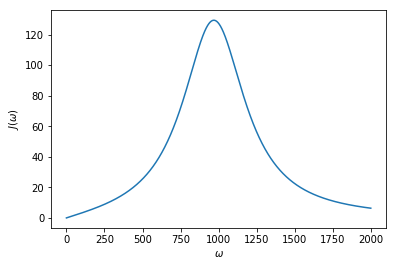

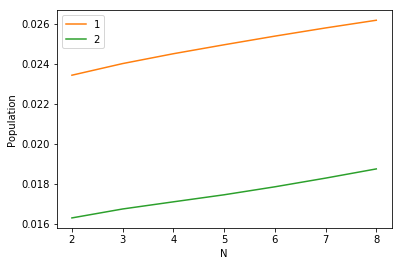

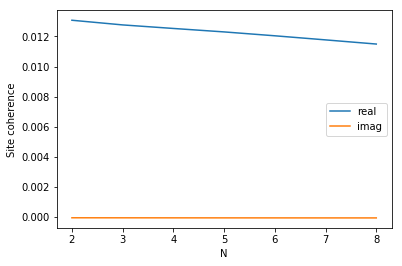

****************************************
RC 1 has occupation of: 4.01661659607
RC 1 has fock state 8 occupation: 0.00127263903577
RC 2 has occupation of: 3.96176063789
RC 2 has fock state 8 occupation: 0.0012602312555
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 1000.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50, 'Gamma_2': 50, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.007957747154594767, 'gamma_2': 0.007957747154594767}
1000


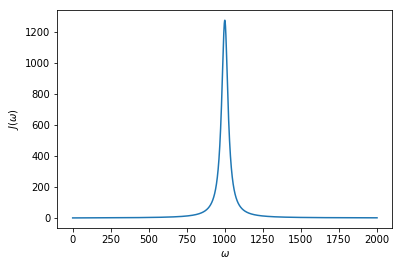

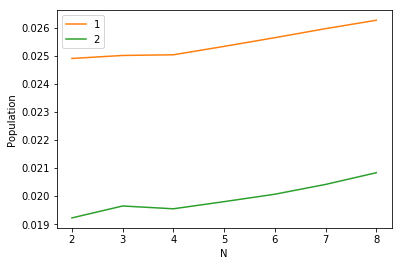

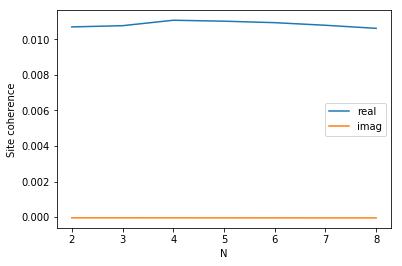

****************************************
RC 1 has occupation of: 3.99560095863
RC 1 has fock state 8 occupation: 0.00137084209482
RC 2 has occupation of: 3.98173969283
RC 2 has fock state 8 occupation: 0.00137671680166
{'kappa_2': 316.22776601683796, 'kappa_1': 316.22776601683796, 'T_EM': 300.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50, 'Gamma_2': 50, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1000, 'w0_2': 1000, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.00000000000001, 'shift1': 100.00000000000001, 'gamma_1': 0.007957747154594767, 'gamma_2': 0.007957747154594767}
1000


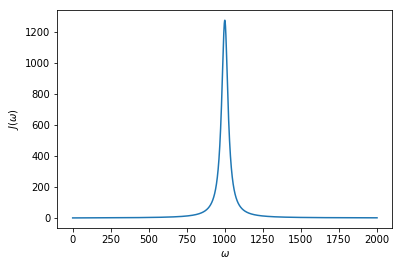

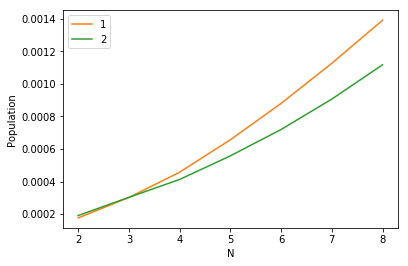

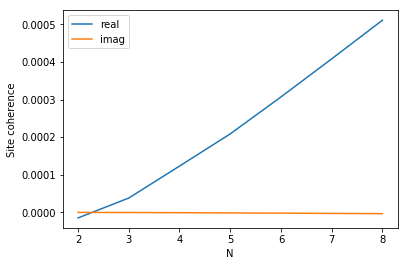

****************************************
RC 1 has occupation of: 4.00079313139
RC 1 has fock state 8 occupation: 0.001177680307
RC 2 has occupation of: 3.98898348461
RC 2 has fock state 8 occupation: 0.0011693567969
{'kappa_2': 346.41016151377545, 'kappa_1': 346.41016151377545, 'T_EM': 2000.0, 'bias': 100.0, 'alpha_2': 63.66197723675813, 'alpha_1': 63.66197723675813, 'T_2': 300.0, 'T_1': 300.0, 'Gamma_1': 50, 'Gamma_2': 50, 'mu': 0.9523809523809523, 'num_cpus': 1, 'w_xx': 4100.0, 'J': <function J_minimal at 0x11ac08578>, 'w0_1': 1200, 'w0_2': 1200, 'V': 200.0, 'w_1': 2100.0, 'w_2': 2000.0, 'dipole_2': 1.0, 'dipole_1': 1.0, 'exc': 2, 'alpha_EM': 1.0, 'N_1': 2, 'N_2': 2, 'shift2': 100.0, 'shift1': 100.0, 'gamma_1': 0.006631455962162306, 'gamma_2': 0.006631455962162306}
1200


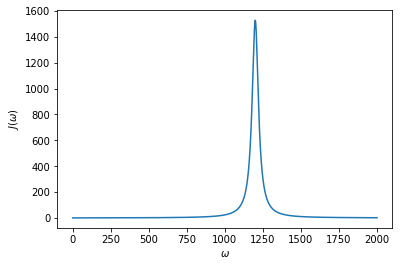

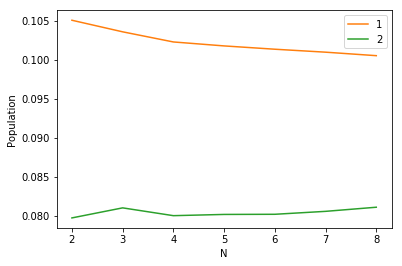

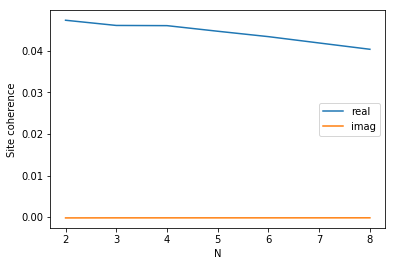

****************************************
RC 1 has occupation of: 3.98378116601
RC 1 has fock state 8 occupation: 0.00132502867577
RC 2 has occupation of: 3.96079318805
RC 2 has fock state 8 occupation: 0.00137529048302


In [48]:
N_vals_c, exp_vals = convergence_plotter(2)
N_vals_c, exp_vals = convergence_plotter(3)
N_vals_c, exp_vals = convergence_plotter(4)
N_vals_c, exp_vals = convergence_plotter(5)
N_vals_c, exp_vals = convergence_plotter(6)
N_vals_c, exp_vals = convergence_plotter(7)
N_vals_c, exp_vals = convergence_plotter(8)
N_vals_c, exp_vals = convergence_plotter(9)

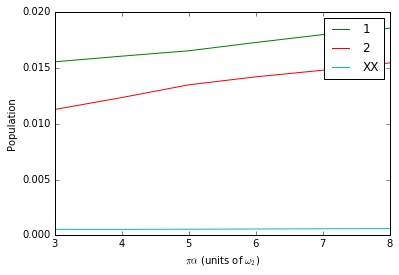

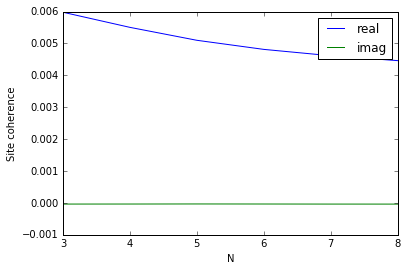

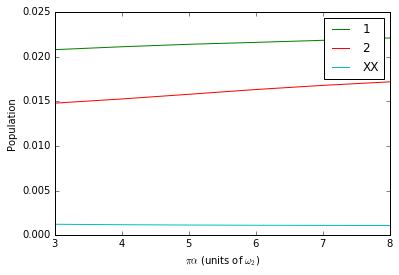

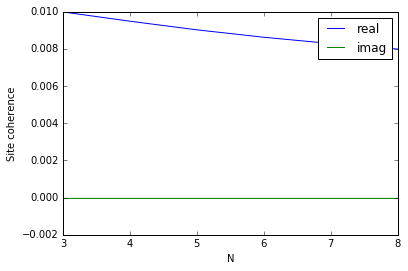

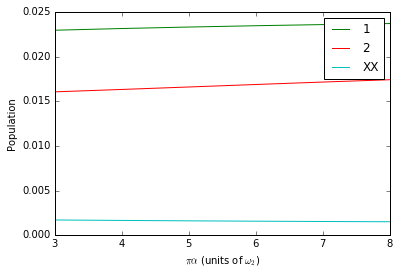

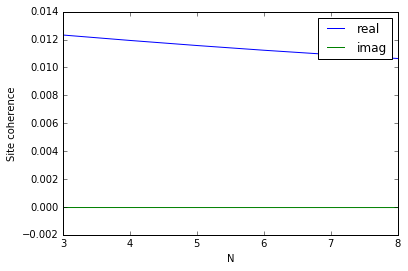

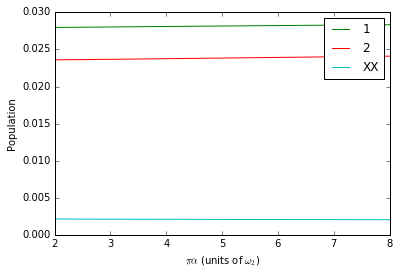

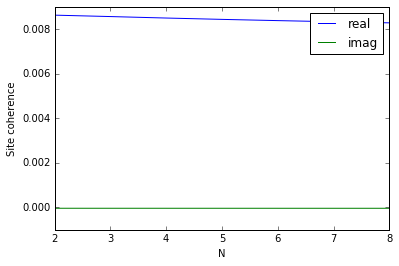

In [79]:

N_vals_c, exp_vals = convergence_plotter(12)
N_vals_c, exp_vals = convergence_plotter(13)
N_vals_c, exp_vals = convergence_plotter(14)

### Populations
Why? 
- In order to see how the phonons effect transitions between dark and bright states given their energy gap
- To see how steadystate population imbalance leads to excitonic coherence

In [22]:
reload(opt)
def N_across_gap(gap, w_0):
    return int(gap/w_0)
def eta_f(eps, V):
    return sqrt(eps**2 +4*(V**2))

def alpha_dependence(bias=100., w_2=2000., V = 100., 
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                lower_prop=0.005, upper_prop=0.5, 
                                 num=20, lower_N=5, upper_N=15, 
                                 num_cpus=1, w_0=None):
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = T_ph, T_ph # Phonon bath temperature
    
    Gamma_1, Gamma_2 = 50., 50.
    if w_0 == None:
        w0_2, w0_1 = gap, gap # underdamped SD parameter omega_0
        upper_N = N_across_gap(w_2, gap)
    else:
        w0_2, w0_1 = w_0, w_0 # underdamped SD parameter omega_0
        upper_N = upper_N
    
    w_xx = w_2 + w_1
    print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}.".format(gap, phonon_energy, w0_2)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.
    
    # electromagnetic bath liouvillians
    N_vals = [int(i) for i in np.linspace(lower_N, upper_N, num)]
    pialphas = np.logspace(np.log10(lower_prop), np.log10(upper_prop), num)
    steady_states = []
    
    for i, pialpha in enumerate(pialphas):
        alpha = w_2*pialpha/pi
        N_1 = N_2 = N = N_vals[i]
        exc = N
        
        silent = False
        if N<=5:
            silent = True
        
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                                silent=silent, 
                                                                shift=True)
        
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        ti = time.time()
        L = L_RC+L_EM_full
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 50
                dt = 1e-3
                if N>9:
                    ff = 40
                    dt = 5e-2
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                 fill_factor=ff, drop_tol=dt)
        steady_states.append(ss)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)
    j = 1
    saved = False
    while not saved:
        directory = 'DATA/ss_wrt_alpha_'+str(j)
        if not os.path.exists(directory):
            os.makedirs(directory)
            save_obj(pialphas, directory+'/pialphas')
            save_obj(steady_states, directory+'/steady_states')
            save_obj(PARAMS, directory+'/PARAMS')
            save_obj(N_vals, directory+'/N_vals')
            saved = True
        else:
            j+=1
    return pialphas, steady_states, PARAMS, N_vals

    
def population_alpha_dependence_plotter(num, eig=False):
    directory = 'DATA/ss_wrt_alpha_'+str(num)
    pialphas  = load_obj(directory+'/pialphas')
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')
    
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    e_ops = [OO_proj, XO_proj, OX_proj, XX_proj, dark, bright]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())    
        expectation_values.append(dat)
        
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['g', '1', '2', 'XX']
    ids = [0,1,2,3]
    if eig:
        labels = ['g', 'dark', 'bright', 'XX']
        ids = [0,4,5,3]
    for i, l in zip(ids, labels):
        plt.plot(pialphas, np.array(expectation_values[i]).real, label=l, color=colors[i])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(r'Population')
    plt.legend()
    plt.show()
    
    return pialphas, expectation_values

def coherence_alpha_dependence_plotter(num, eig=False):
    directory = 'DATA/ss_wrt_alpha_'+str(num)
    pialphas  = load_obj(directory+'/pialphas')
    steady_states = load_obj(directory+'/steady_states')
    PARAMS = load_obj(directory+'/PARAMS')
    N_vals = load_obj(directory+'/N_vals')
    OO = basis(4,0)
    XO = basis(4,1)
    OX = basis(4,2)
    XX = basis(4,3)
    site_coherence = OX*XO.dag()
    
    energies, states = exciton_states(PARAMS, shift=False) 
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = dark_vec*dark_vec.dag()
    bright = bright_vec*bright_vec.dag()
    exciton_coherence = dark_vec*bright_vec.dag()
    e_ops = [site_coherence, exciton_coherence]
    expectation_values = []
    for e_op in e_ops:
        dat = []
        for i, ss in enumerate(steady_states):
            I = enr_identity([N_vals[i],N_vals[i]], N_vals[i])
            dat.append((tensor(e_op,I)*ss).tr())    
        expectation_values.append(dat)
        
    ''' make the RC observable operators '''
    
    
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['real', 'imag.']
    idx = 0
    y_lab = 'Site'
    if eig:
        idx = 1
        y_lab = 'Eigenstate'
    plt.figure
    plt.plot(pialphas, np.array(expectation_values[idx]).real, label=labels[0], color=colors[0])
    plt.plot(pialphas, np.array(expectation_values[idx]).imag, label=labels[1], color=colors[1])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(y_lab+' coherence')
    plt.legend()
    plt.show()
    return pialphas, expectation_values

[5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 9] [ 0.05        0.05644189  0.06371375  0.07192249  0.08118884  0.09164904
  0.1034569   0.11678607  0.13183254  0.14881757  0.16799091  0.18963451
  0.21406662  0.24164651  0.27277974  0.30792411  0.3475964   0.39237999
  0.4429334   0.5       ]


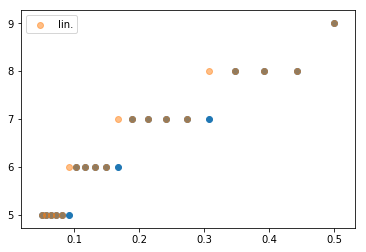

In [80]:
num = 20
n_min = 5
N_vals = [int(i) for i in np.logspace(np.log10(n_min),np.log10(9), num)]
N_vals_lin = [int(i) for i in np.linspace(n_min,9, num)]
pialphas = np.logspace(np.log10(0.05), np.log10(0.5), num)
print N_vals, pialphas
plt.scatter(pialphas, N_vals)
plt.scatter(pialphas, N_vals_lin, label='lin.', alpha=0.5)
plt.legend()
plt.show()

In [28]:
pialphast, populationst, paramst, N_valst = alpha_dependence(bias=50., w_2=2000., V = 100., num_cpus=3)

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 223.60679775.
The operators took 4.18993997574 and have dimension 104.
Building the RC Liouvillian took 4.209 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7537369728 seconds.
6  N= 6
full steady states took 11.170 seconds
The operators took 4.19157195091 and have dimension 104.
Building the RC Liouvillian took 4.197 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7460970879 seconds.
7  N= 6
full steady states took 12.147 seconds
The operators took 4.19356179237 and have dimension 104.
Building the RC Liouvillian took 4.211 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 10.7

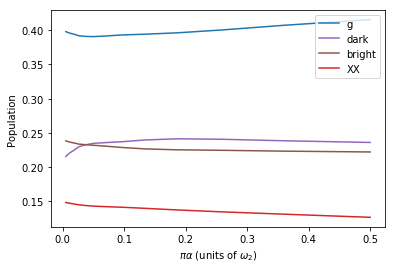

In [45]:
_, _ = population_alpha_dependence_plotter(8, eig=True)

## Parameters
Choose somes basic parameter regimes to use
- we want the gap to be larger than room phonon temperature and the same for both hetero and homodimer. This will show the differences in exciton population given the change in phonon-coupling for the same exciton energies but with different "darkness" and "brightness" (weaker in the hetero).
- WE can then cool down the phonons to turn off dark-state protection. Also look at coherence discrepancies.

In [82]:
print 300*0.695
eps, V = 50, 100
hetero_gap = eta_f(eps, V)
homo_V =  eta_f(eps, V)/2
homo_gap = eta_f(0., eta_f(eps, V)/2)
print hetero_gap, homo_V, homo_gap
print N_across_gap(2000., hetero_gap)

208.5
206.155281281 103.07764064 206.155281281
9



### Phonon bath parameters
- Changing the peak position will allow the phonons to couple to the gap, causing transitions. Though, the phonons may not have enough thermal energy to cause upwards transitions. This means that for dark state protection, we need a broad or **resonant phonon bath** with thermal energy smaller than the energy gap.

### Dimer electronic parameters
#### one heterodimers: with medium energy gap: $V>\epsilon$ .
- We can change the phonon temperature to turn off and on dark-state protection.
- More interesting regime as the bare excitonic states will be fully delocalised which 

#### one homodimer with same gap as hetero. (larger than thermal phonon energy at room T).
$V_{homo} = \eta/2$
- Totally dark and bright states. The dark state is only populated via mixing due to the phonons and due to dephasing which destroys the dark state (same thing?). We should see that for weak phonons the dark state is populated less highly than at stronger coupling.

- **Q: do the effects of the two baths add up?** Perhaps two-phonon processes could occur if the frequency is half that of the eta.

In [23]:
eps, V = 50, 100
homo_V =  eta_f(eps, V)/2
T_room = 300.
T_cool = 100.
#pialphas1, populations1, params1, N_vals1 = alpha_dependence(bias=eps, w_2=2000., V = V, T_ph = T_room,
#                                                             num=20, lower_N=5, num_cpus=3)
pialphas2, populations2, params2, N_vals2 = alpha_dependence(bias=eps, w_2=2000., V = V, T_ph = T_cool,
                                                             num=20, lower_N=5, num_cpus=3)
#pialphas3, populations3, params3, N_vals3 = alpha_dependence(bias=0., w_2=2000., V = homo_V, 
#                                                             num=20, lower_N=5, num_cpus=3)


Gap is 206.155281281. Phonon thermal energy is 69.5. Phonon SD peak is 206.155281281.
The operators took 6.65596795082 and have dimension 104.
Building the RC Liouvillian took 6.672 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 19.6212460995 seconds.
6  N= 6
full steady states took 33.511 seconds
The operators took 7.59113812447 and have dimension 104.
Building the RC Liouvillian took 7.609 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 20.3003089428 seconds.
7  N= 6
full steady states took 28.830 seconds
The operators took 7.2895359993 and have dimension 104.
Building the RC Liouvillian took 7.305 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
Full optical Liouvillian took 20.7

bias=50, V = 100, eta = 206.155281281 


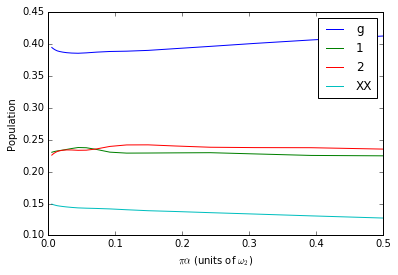

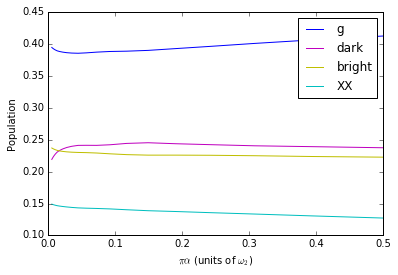

bias=50, V = 100, eta = 206.155281281 


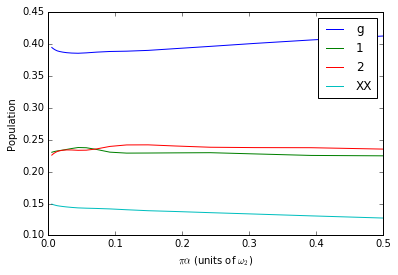

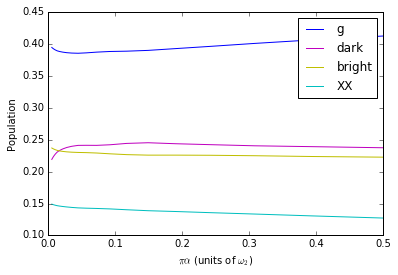

bias=0, V = 103.07764064, eta = 206.155281281 


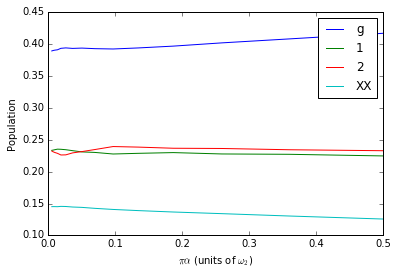

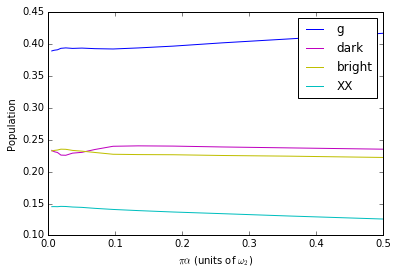

In [8]:
print "bias=50, V = 100, eta = {} ".format(sqrt(50**2 +4*(100**2)))
pa1, p1 = population_alpha_dependence_plotter(9)
pa1, p1 = population_alpha_dependence_plotter(9, eig=True)
print "bias=50, V = 100, eta = {} ".format(sqrt(50**2 +4*(100**2)))
pa1, p1 = population_alpha_dependence_plotter(10)
pa1, p1 = population_alpha_dependence_plotter(10, eig=True)
print "bias=0, V = {}, eta = {} ".format(homo_V, homo_V*2)
pa1, p1 = population_alpha_dependence_plotter(1)
pa1, p1 = population_alpha_dependence_plotter(1, eig=True)

In [40]:
pialphas, populations = populations_alpha_dependence(num=15, lower_N=7, upper_N=9, num_cpus=3)

Gap is 223.60679775. Phonon thermal energy is 208.5. Phonon SD peak is 140.0.
The operators took 7.99551606178 and have dimension 136.
Building the RC Liouvillian took 8.004 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 19.9804120064 seconds.
1  N= 7
full steady states took 35.243 seconds
The operators took 8.12072110176 and have dimension 136.
Building the RC Liouvillian took 8.128 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 20.0227119923 seconds.
2  N= 7
full steady states took 37.476 seconds
The operators took 8.21633005142 and have dimension 136.
Building the RC Liouvillian took 8.223 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
Full optical Liouvillian took 20.20491790

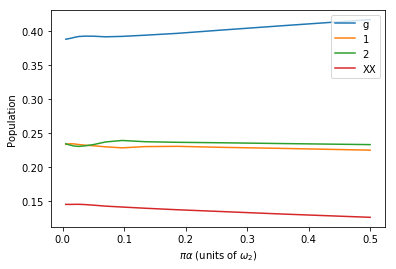

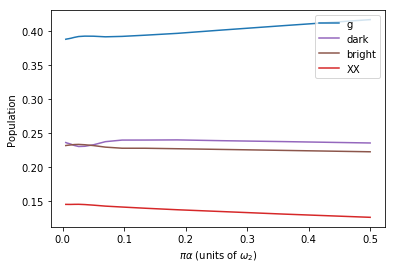

In [41]:
pa1, p1 = alpha_dependence_plotter(pialphas, populations)
pa1, p1 = alpha_dependence_plotter(pialphas, populations, eig=True)

### Coherences
Why?
- We are going to relate steadystate eigenstate coherences to the site basis coherence and population differences
- Seeing any maxima of coherence would be interesting (after shifts are accounted for)

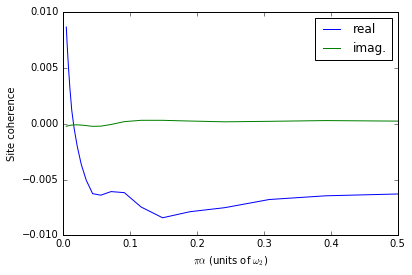

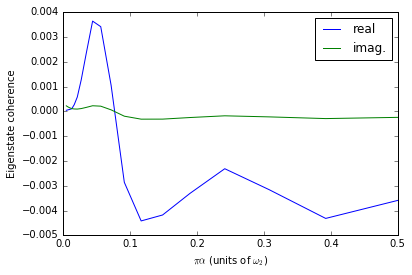

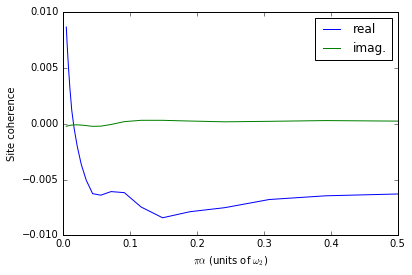

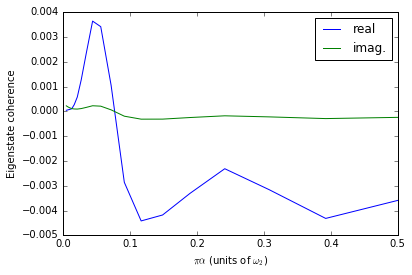

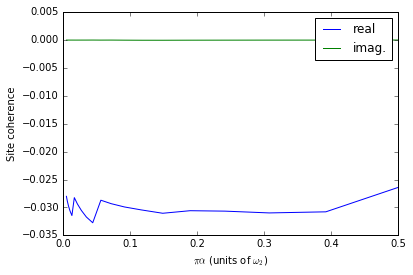

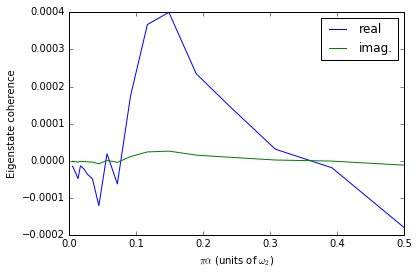

In [21]:
pa1, p1 = coherence_alpha_dependence_plotter(9)
pa1, p1 = coherence_alpha_dependence_plotter(9, eig=True)
pa1, p1 = coherence_alpha_dependence_plotter(10)
pa1, p1 = coherence_alpha_dependence_plotter(10, eig=True)
pa1, p1 = coherence_alpha_dependence_plotter(11)
pa1, p1 = coherence_alpha_dependence_plotter(11, eig=True)

In [2]:


        
def plot_dynamics(bias=100., w_2=2000., V = 100., N=3, 
                  alpha_1=100., alpha_2=100., T_EM=0., 
                  T_ph =300., alpha_EM=1., shift=True,dimer_init='one'):
    OO = basis(4,0)
    XO = basis(4,1)
    OX = basis(4,2)
    XX = basis(4,3)
    sigma_m1 = OX*XX.dag() + OO*XO.dag()
    sigma_m2 = XO*XX.dag() + OO*OX.dag()
    sigma_x1 = sigma_m1+sigma_m1.dag()
    sigma_x2 = sigma_m2+sigma_m2.dag()
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = 300., 300. # Phonon bath temperature

    wc = 1*53.08 # Ind.-Boson frame phonon cutoff freq
    Gamma_1, Gamma_2 = 50., 50.
    w0_2, w0_1 = w_2*0.07, w_2*0.07 # underdamped SD parameter omega_0
    w_xx = w_2 + w_1
    N_1, N_2 = N, N # set Hilbert space sizes
    exc = N_1
    I_dimer = qeye(4)
    I = enr_identity([N_1,N_2], exc)
    num_cpus = 1
    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2', 'wc',
                   'w0_1', 'w0_2', 'alpha_1', 'alpha_2', 'N_1', 'N_2', 'exc', 
                   'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    

    '''Defining DM states'''
    site_coherence = tensor(OX*XO.dag(), I)
    OO = tensor(OO*OO.dag(), I)
    XO = tensor(XO*XO.dag(), I)
    OX = tensor(OX*OX.dag(), I)
    XX = tensor(XX*XX.dag(), I)

    #Now we build all of the mapped operators and RC Liouvillian.

    # electromagnetic bath liouvillians

    opts = qt.Options(num_cpus=1, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    ''' generate the RC liouvillian '''
    L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                            silent=False, 
                                                            shift=True) # Get the mapped parameters back
    #H_dim = w_1*XO*XO.dag() + w_2*OX*OX.dag() + w_xx*XX*XX.dag() + V*(XO*OX.dag() + OX*XO.dag())
    import utils as ut
    reload(ut)
    energies, states = ut.exciton_states(PARAMS, shift=False)
    bright_vec = states[1]
    dark_vec = states[0]
    #print bright_vec, (sigma_m1 + sigma_m2)*bright_vec
    #print dark_vec, np.dot((sigma_m1 + sigma_m2).full(), dark_vec.full())
    dark = tensor(dark_vec*dark_vec.dag(), I)
    bright = tensor(bright_vec*bright_vec.dag(), I)
    exciton_coherence = tensor(dark_vec*bright_vec.dag(), I)
    
    wRC_1, wRC_2 =  PARAMS['w0_1'], PARAMS['w0_2']
    kappa_1, kappa_2 = PARAMS['kappa_1'],PARAMS['kappa_2']
    ''' make the RC observable operators '''
    atemp = enr_destroy([N_1,N_2], exc)
    n_RC_1 = Occupation(wRC_1, T_1)
    n_RC_2 = Occupation(wRC_2, T_2)
    phonon_num_1 = atemp[0].dag()*atemp[0]
    phonon_num_2 = atemp[1].dag()*atemp[1]
    x_1 = (atemp[0].dag()+atemp[0])
    x_2 = (atemp[1].dag()+atemp[1])
    Phonon_1 = tensor(I_dimer, phonon_num_1)
    Phonon_2 = tensor(I_dimer, phonon_num_2)
    disp_1 = tensor(I_dimer, x_1)
    disp_2 = tensor(I_dimer, x_2)
    
    opts = qt.Options(num_cpus=num_cpus, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    
    thermal_RCs = enr_thermal_dm([N_1, N_2], exc, [n_RC_1, n_RC_2])
    if dimer_init=='one':
        rho_0 = tensor(basis(4,1)*basis(4,1).dag(), thermal_RCs)
    elif dimer_init in ('zero', 'ground'):
        rho_0 = tensor(basis(4,0)*basis(4,0).dag(), thermal_RCs)
    elif dimer_init=='bright':
        rho_0 = tensor(bright_vec*bright_vec.dag(), thermal_RCs)
    elif dimer_init=='dark':
        rho_0 = tensor(dark_vec*dark_vec.dag(), thermal_RCs)
    elif dimer_init== 'exc_coherence':
        rho_0 = tensor(0.5*(dark_vec*bright_vec.dag()+bright_vec*dark_vec.dag()), thermal_RCs)
    else:
        print "The descriptor for electronic state is not an option"
        raise ValueError
    #timelist = np.linspace(0,3,1000)
    e_ops = [XO, exciton_coherence, disp_1, dark, bright]
    timelist = np.linspace(0,0.6,10000)
    options = qt.solver.Options(nsteps=1500)
    L_EM_full = L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=False)
    ti = time.time()
    L = L_RC+L_EM_full
    data_f = qt.mesolve(H[1], rho_0, timelist, c_ops=L, 
                        e_ops=e_ops, 
                        options=options, progress_bar=True)
    print "full dynamics took {:0.3f} seconds".format(time.time()-ti)
    
    
    L_EM_add = L_phenom(I, PARAMS)
    ti = time.time()
    L = L_RC+L_EM_add
    data_add = qt.mesolve(H[1], rho_0, timelist, c_ops=L, 
                      e_ops=e_ops, options=options)
    
    print "additive dynamics took {:0.3f} seconds".format(time.time()-ti)
    L_EM_add = L_non_rwa(tensor(H[0],I), tensor(sigma,I), PARAMS, silent=False)
    ti = time.time()
    L = L_RC+L_EM_add
    data_adns = qt.mesolve(H[1], rho_0, timelist, c_ops=L, 
                      e_ops=e_ops, options=options)
    print "additive dynamics took {:0.3f} seconds".format(time.time()-ti)
    
    return data_f, data_adns, data_add
    



In [139]:
dat1 = []
dat1.append(plot_dynamics(bias=0., w_2=4000., V = 100., N=6, 
                          alpha_1=50., alpha_2=50., T_EM=0., 
                          T_ph =300., alpha_EM=1., dimer_init='dark'))


The operators took 18.6476781368 and have dimension 104.
Building the RC Liouvillian took 19.333 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
0.0 0.0
Full optical Liouvillian took 11.8200778961 seconds.
10.0%. Run time:  11.30s. Est. time left: 00:00:01:41
20.0%. Run time:  22.92s. Est. time left: 00:00:01:31
30.0%. Run time:  34.64s. Est. time left: 00:00:01:20
40.0%. Run time:  46.41s. Est. time left: 00:00:01:09
50.0%. Run time:  58.98s. Est. time left: 00:00:00:58
60.0%. Run time:  71.11s. Est. time left: 00:00:00:47
70.0%. Run time:  83.27s. Est. time left: 00:00:00:35
80.0%. Run time:  95.52s. Est. time left: 00:00:00:23
90.0%. Run time: 107.68s. Est. time left: 00:00:00:11
Total run time: 119.78s
full dynamics took 119.990 seconds
It took 0.0395460128784 seconds to build the phenomenological Liouvillian
additive dynamics took 28.372 seconds
Full optical Liouvillian took 10.0598468781 seconds.
a

In [37]:
reload(opt)
def coherences_alpha_dependence(bias=100., w_2=2000., V = 100., 
                                 T_EM=6000., T_ph =300., 
                                 alpha_EM=1., shift=True,
                                lower_prop=0.005, upper_prop=0.5, 
                                 num=15, lower_N=3, upper_N=15, num_cpus=1):
    gap = sqrt(bias**2 +4*(V**2))
    phonon_energy = T_ph*0.695
    
    OO = basis(4,0)
    XO = basis(4,1)
    OX = basis(4,2)
    XX = basis(4,3)
    sigma_m1 = OX*XX.dag() + OO*XO.dag()
    sigma_m2 = XO*XX.dag() + OO*OX.dag()
    sigma_x1 = sigma_m1+sigma_m1.dag()
    sigma_x2 = sigma_m2+sigma_m2.dag()
    w_1 = w_2 + bias
    dipole_1, dipole_2 = 1., 1.
    mu = w_2*dipole_2/(w_1*dipole_1)
    sigma = sigma_m1 + mu*sigma_m2
    T_1, T_2 = 300., 300. # Phonon bath temperature

    wc = 1*53.08 # Ind.-Boson frame phonon cutoff freq
    Gamma_1, Gamma_2 = 50., 50.
    w0_2, w0_1 = w_2*0.07, w_2*0.07 # underdamped SD parameter omega_0
    w_xx = w_2 + w_1
    print "Gap is {}. Phonon thermal energy is {}. Phonon SD peak is {}.".format(gap, phonon_energy, w0_2)
    I_dimer = qeye(4)

    J = J_minimal

    PARAM_names = ['w_1', 'w_2', 'V', 'bias', 'w_xx', 'T_1', 'T_2', 'wc',
                   'w0_1', 'w0_2', 'T_EM', 'alpha_EM','mu', 'num_cpus', 'J', 
                   'dipole_1','dipole_2', 'Gamma_1', 'Gamma_2']
    scope = locals() # Lets eval below use local variables, not global
    PARAMS = dict((name, eval(name, scope)) for name in PARAM_names)
    
    '''Defining DM states'''
    

    #Now we build all of the mapped operators and RC Liouvillian.

    # electromagnetic bath liouvillians

    opts = qt.Options(num_cpus=1, store_states=True)
    ncolors = len(plt.rcParams['axes.prop_cycle'])
    N_vals = [int(i) for i in np.logspace(np.log10(lower_N),np.log10(upper_N), num)]
    pialphas = np.logspace(np.log10(lower_prop), np.log10(upper_prop), num)
    populations = []
    
    for i, pialpha in enumerate(pialphas):
        alpha = w_2*pialpha/pi
        N_1 = N_2 = N = N_vals[i]
        silent = False
        if N<5:
            silent = True
        exc = N
        PARAMS.update({'alpha_1': alpha, 'alpha_2': alpha})
        PARAMS.update({'N_1': N_1, 'N_2': N_2})
        PARAMS.update({'exc': exc})
        I = enr_identity([N_1,N_2], exc)
        ''' generate the RC liouvillian '''
        # Get the mapped parameters back
        L_RC, H, A_1, A_2, SIG_1, SIG_2, PARAMS = RC.RC_mapping(PARAMS, 
                                                                silent=silent, 
                                                                shift=True)
        site_coherence = tensor(OX*XO.dag(), I)
        OO_proj = tensor(OO*OO.dag(), I)
        XO_proj = tensor(XO*XO.dag(), I)
        OX_proj = tensor(OX*OX.dag(), I)
        XX_proj = tensor(XX*XX.dag(), I)
        # dark and bright states defined without shifts
        energies, states = exciton_states(PARAMS, shift=False) 
        bright_vec = states[1]
        dark_vec = states[0]
        
        exciton_coherence = tensor(dark_vec*bright_vec.dag(), I)

        wRC_1, wRC_2 =  PARAMS['w0_1'], PARAMS['w0_2']
        kappa_1, kappa_2 = PARAMS['kappa_1'],PARAMS['kappa_2']
        ''' make the RC observable operators '''

        opts = qt.Options(num_cpus=num_cpus, store_states=True)

        #timelist = np.linspace(0,3,1000)
        e_ops = [OO_proj, XO_proj, OX_proj, XX_proj, dark, bright]
        timelist = np.linspace(0,0.6,10000)
        options = qt.solver.Options(nsteps=1500)
        L_EM_full = opt.L_non_rwa(H[1], tensor(sigma,I), PARAMS, silent=silent)
        ti = time.time()
        L = L_RC+L_EM_full
        if N >5:
            print i+1, " N=",N
            method='iterative-lgmres'
            use_precond = True
            ff=100
            dt=1e-4
            if N>7:
                ff = 50
                dt = 1e-3
                if N>9:
                    ff = 30
                    dt = 1e-2
        else:
            method = 'direct'
            use_precond = False
            ff=100
            dt=1e-4
        ss = steadystate(H[1], [L], method=method, use_precond=use_precond,
                                                 fill_factor=ff, drop_tol=dt)
        dat = []
        for e_op in e_ops:
            dat.append((e_op*ss).tr())
        populations.append(dat)
        if not silent:
            print "full steady states took {:0.3f} seconds".format(time.time()-ti)

    return pialphas, populations

def alpha_dependence_plotter(pialphas, populations, eig=False):
    plt.figure()
    colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    labels = ['g', '1', '2', 'XX']
    ids = [0,1,2,3]
    if eig:
        labels = ['g', 'dark', 'bright', 'XX']
        ids = [0,4,5,3]
    populations = np.array(populations).T
    for i, l in zip(ids, labels):
        plt.plot(pialphas, populations[i], label=l, color=colors[i])
    plt.xlabel(r'$\pi \alpha$ (units of $\omega_2$)')
    plt.ylabel(r'Population')
    plt.legend()
    plt.show()
    return pialphas, populations

## Dark state protection

In [141]:
print np.sqrt(0**2 + 4*(100**2))
print 4000.*0.07
print 300.*0.695


200.0
280.0
208.5


Can the phonons overcome the dark-bright state gap? 

The phonons couple strongly to transitions on the same order as the splitting. The phonons also have enough thermal energy to overcome the gap. Try increasing the gap to see if the dark-state population is suppressed.

In [142]:
print np.sqrt(0**2 + 4*(200**2))
print 4000.*0.07
print 300.*0.695

400.0
280.0
208.5


In [143]:
dat2 = []
dat2.append(plot_dynamics(bias=0., w_2=4000., V = 200., N=6, 
                          alpha_1=50., alpha_2=50., T_EM=0., 
                          T_ph =300., alpha_EM=1., dimer_init='dark'))

The operators took 19.8447618484 and have dimension 104.
Building the RC Liouvillian took 20.535 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
0.0 0.0
Full optical Liouvillian took 11.9835619926 seconds.
10.0%. Run time:  12.25s. Est. time left: 00:00:01:50
20.0%. Run time:  24.55s. Est. time left: 00:00:01:38
30.0%. Run time:  37.77s. Est. time left: 00:00:01:28
40.0%. Run time:  51.42s. Est. time left: 00:00:01:17
50.0%. Run time:  63.81s. Est. time left: 00:00:01:03
60.0%. Run time:  76.67s. Est. time left: 00:00:00:51
70.0%. Run time:  90.89s. Est. time left: 00:00:00:38
80.0%. Run time: 104.18s. Est. time left: 00:00:00:26
90.0%. Run time: 117.89s. Est. time left: 00:00:00:13
Total run time: 131.20s
full dynamics took 131.411 seconds
It took 0.0400681495667 seconds to build the phenomenological Liouvillian
additive dynamics took 33.155 seconds
Full optical Liouvillian took 11.8388538361 seconds.
a

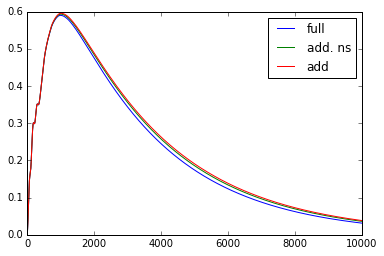

In [144]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()"""
plt.figure()
for d in dat2:
    for i, l in enumerate(d):
        plt.plot(l.expect[4].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [133]:
print np.sqrt(400**2 + 4*(100**2))
print 4000.*0.07
print 300.*0.695

447.2135955
280.0
208.5


In [4]:
dat3 = []
dat3.append(plot_dynamics(bias=100., w_2=4000., V = 150., N=7, 
                          alpha_1=100., alpha_2=100., T_EM=6000., 
                          T_ph =300., alpha_EM=1., dimer_init='ground'))

The operators took 34.3376498222 and have dimension 136.
Building the RC Liouvillian took 35.975 seconds.
****************************************************************
It is 18496by18496. The full basis would be 38416by38416
100.0 100.0
Full optical Liouvillian took 33.5340120792 seconds.
10.0%. Run time:  43.80s. Est. time left: 00:00:06:34
20.0%. Run time:  89.34s. Est. time left: 00:00:05:57
30.0%. Run time: 129.85s. Est. time left: 00:00:05:02
40.0%. Run time: 170.15s. Est. time left: 00:00:04:15
50.0%. Run time: 210.50s. Est. time left: 00:00:03:30
60.0%. Run time: 250.98s. Est. time left: 00:00:02:47
70.0%. Run time: 291.38s. Est. time left: 00:00:02:04
80.0%. Run time: 331.73s. Est. time left: 00:00:01:22
90.0%. Run time: 372.19s. Est. time left: 00:00:00:41
Total run time: 412.52s
full dynamics took 413.356 seconds
100.0 100.0
It took 0.0649590492249 seconds to build the phenomenological Liouvillian
additive dynamics took 73.491 seconds
Full optical Liouvillian took 17.68905

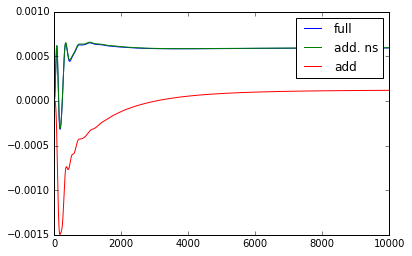

In [7]:

"""for d in dat:
    
    for i, l in enumerate(d):
        plt.plot(l.expect[1].real, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()"""
plt.figure()
for d in dat3:
    for i, l in enumerate(d):
        plt.plot(l.expect[1].imag, label=lab[i])
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [20]:
dat = []
dat.append(plot_dynamics(bias=100., w_2=4000., V = 100., N=6, 
                          alpha_1=30., alpha_2=30., T_EM=0., 
                          T_ph =300., alpha_EM=1.))

The operators took 18.3629541397 and have dimension 104.
Building the RC Liouvillian took 19.004 seconds.
****************************************************************
It is 10816by10816. The full basis would be 20736by20736
47.1238898038
dynamics took 82.425 seconds


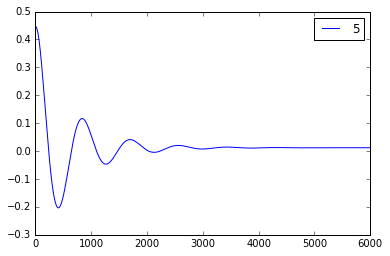

In [21]:
l = iter(range(5,8))
for d in dat:
    plt.plot(d.expect[1].real, label=l.next())
    #plt.plot(d.expect[0].imag, ls='dashed')
plt.legend()
plt.show()

In [38]:
dat = []
for n in range(5,8):
    print "N={}".format(n)
    dat.append(plot_dynamics(bias=100., w_2=4000., V = 100., N=n, 
                  alpha_1=30., alpha_2=30., T_EM=0., 
                  T_ph =300., alpha_EM=1.))
    

N=5


KeyboardInterrupt: 

In [51]:
plot_dynamics(bias=100., w_2=4000., V = 100., N=8, 
                          alpha_1=30., alpha_2=30., T_EM=0., 
                          T_ph =300., alpha_EM=1.)

The operators took 63.578772068 and have dimension 172.
Building the RC Liouvillian took 67.220 seconds.
****************************************************************
It is 29584by29584. The full basis would be 65536by65536
[3938.1966011250106, 4161.8033988749894] [     0.            200.            200.            400.            400.
    400.            600.            600.            600.            600.
    800.            800.            800.            800.            800.
   1000.           1000.           1000.           1000.           1000.
   1000.           1200.           1200.           1200.           1200.
   1200.           1200.           1200.           1400.           1400.
   1400.           1400.           1400.           1400.           1400.
   1400.           1600.           1600.           1600.           1600.
   1600.           1600.           1600.           3994.74591193
   4145.14383728   4194.74592259   4261.18374568   4329.74670772
   4345.14415717  

In [35]:
3994.74 - 4032.44

-37.70000000000027

In [ ]:
46.2080

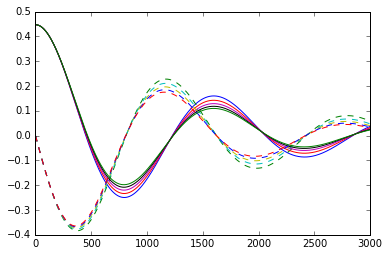

In [98]:
for d in dat:
    plt.plot(d.expect[1].real)
    plt.plot(d.expect[1].imag, ls='dashed')
plt.show()